In [1]:
import argparse
import torch
import torch.nn as nn
#import data
import utils
#import model
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

/store/DAMTP/na673/mamba/envs/lion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fwd_gradients(obj, x):
    dummy = torch.ones_like(obj)
    derivative = torch.autograd.grad(obj, x, dummy, create_graph= True)[0]
    return derivative

def burgers_equation(u, tx):
    u_tx = fwd_gradients(u, tx)
    u_t = u_tx[:, 0:1]
    u_x = u_tx[:, 1:2]
    u_xx = fwd_gradients(u_x, tx)[:, 1:2]
    e = u_t + u*u_x - (0.01/np.pi)*u_xx
    return e

def ac_equation(u, tx):
    u_tx = fwd_gradients(u, tx)
    u_t = u_tx[:, 0:1]
    u_x = u_tx[:, 1:2]
    u_xx = fwd_gradients(u_x, tx)[:, 1:2]
    e = u_t -0.0001*u_xx + 5*u**3 - 5*u
    return e 

def resplot(x, t, t_data, x_data, Exact, u_pred):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(x, Exact[:,0],'-')
    plt.plot(x, u_pred[:,0],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("Initial condition ($t=0$)")
    
    plt.subplot(2, 2, 2)
    t_step = int(0.25*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.25$")
    
    plt.subplot(2, 2, 3)
    t_step = int(0.5*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.5$")
    
    plt.subplot(2, 2, 4)
    t_step = int(0.99*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.99$")
    plt.show()
    plt.close()

In [3]:
def bg_generator(num_t, num_x, typ='train'):
    N_f = num_t*num_x
    t = np.linspace(0, 1, num_t).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, num_x).reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    
    # Initial condition and boundary condition
    u = np.zeros((N, T))  # N x T
    u[:,0:1] = -np.sin(np.pi*x)
    
    t_data = T_star.flatten()[:, None]
    x_data = X_star.flatten()[:, None]
    u_data = u.flatten()[:, None]
    
    t_data_f = t_data.copy()
    x_data_f = x_data.copy()
    
    if typ == 'train':
        idx = np.random.choice(np.where((x_data == -1) | (x_data == 1))[0], num_t)
        t_data = t_data[idx]
        x_data = x_data[idx]
        u_data = u_data[idx]
        
        init_idx = np.random.choice(N-1, num_x-2, replace=False) + 1
        t_data = np.concatenate([t_data, np.zeros((num_x-2,1))], axis=0)
        x_data = np.concatenate([x_data, x[init_idx]], axis=0)
        u_data = np.concatenate([u_data, u[init_idx,0:1]], axis=0)
        
        return t_data, x_data, u_data, t_data_f, x_data_f
   
    else:
        return t_data_f, x_data_f

def ac_generator(num_t, num_x, typ='train'):
    N_f = num_t*num_x
    t = np.linspace(0, 1, num_t).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, num_x).reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    
    # Initial condition and boundary condition
    u = np.zeros((N, T))  # N x T
    u[:,0:1] = (x**2)*np.cos(np.pi*x)
    u[0,:] = -np.ones(T) 
    u[-1,:] = u[0,:]
    
    t_data = T_star.flatten()[:, None]
    x_data = X_star.flatten()[:, None]
    u_data = u.flatten()[:, None]
    
    t_data_f = t_data.copy()
    x_data_f = x_data.copy()
    
    if typ == 'train':
        idx = np.random.choice(np.where((x_data == -1) | (x_data == 1))[0], num_t)
        t_data = t_data[idx]
        x_data = x_data[idx]
        u_data = u_data[idx]
        
        init_idx = np.random.choice(N-1, num_x-4, replace=False) + 1
        t_data = np.concatenate([t_data, np.ones((2,1)), np.zeros((num_x-4,1))], axis=0)
        x_data = np.concatenate([x_data, np.array([[-1], [1]]), x[init_idx]], axis=0)
        u_data = np.concatenate([u_data, -np.ones((2,1)), u[init_idx,0:1]], axis=0)
        
        return t_data, x_data, u_data, t_data_f, x_data_f
   
    else:
        return t_data_f, x_data_f

In [4]:
class LinearBlock(nn.Module):

    def __init__(self, in_nodes, out_nodes):
        super(LinearBlock, self).__init__()
        self.layer = nn.utils.weight_norm(nn.Linear(in_nodes, out_nodes), dim = 0)

    def forward(self, x):
        x = self.layer(x)
        x = torch.tanh(x) 
        return x

class PINN(nn.Module):

    def __init__(self, layer_list):
        super(PINN, self).__init__()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.input_layer = nn.utils.weight_norm(nn.Linear(layer_list[0], layer_list[1]), dim = 0)
        self.hidden_layers = self._make_layer(layer_list[1:-1])
        self.output_layer = nn.Linear(layer_list[-2], layer_list[-1])
        
    def _make_layer(self, layer_list):
        layers = []
        for i in range(len(layer_list) - 1):
            block = LinearBlock(layer_list[i], layer_list[i + 1])
            layers.append(block)
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.input_layer(x)
        x = torch.tanh(x) 
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)

def pinn(layer_list):
    model = PINN(layer_list)
    model.apply(weights_init)
    return model

In [5]:
num_t = 100
num_x = 256
num_epochs = 50000
num_hidden = 4
num_nodes = 128
lr = 1e-4

In [6]:
# Select a partial differential equation
eq = 'ac' # or 'bg'  

In [7]:
device = torch.device("cuda:0")
print("Operation mode: ", device)

Operation mode:  cuda:0


In [8]:
if eq == 'bg':
    t_data, x_data, u_data, t_data_f, x_data_f = bg_generator(num_t, num_x)  
elif eq == 'ac':
    t_data, x_data, u_data, t_data_f, x_data_f = ac_generator(num_t, num_x)
else:
    print("There exists no equation.")
    exit(0)

In [9]:
variables = torch.FloatTensor(np.concatenate((t_data, x_data), 1)).to(device)
variables_f = torch.FloatTensor(np.concatenate((t_data_f, x_data_f), 1)).to(device)
variables_f.requires_grad = True
u_data = torch.FloatTensor(u_data).to(device)

In [10]:
layer_list = [2] + num_hidden * [num_nodes] + [1]
pinn = pinn(layer_list).to(device)

In [11]:
optimizer = torch.optim.Adam(pinn.parameters(), betas=(0.999,0.999), lr=lr)
loss_graph = []
ls = 1e-3
bep = 0

In [12]:
for ep in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        
        # Full batch
        u_hat = pinn(variables)
        u_hat_f = pinn(variables_f)
        
        if eq == 'bg':
            loss_f = torch.mean(burgers_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'ac':
            loss_f = torch.mean(ac_equation(u_hat_f, variables_f) ** 2)
            
        loss_u = torch.mean((u_hat - u_data) ** 2)
        loss = loss_f + loss_u
        loss.backward() 
        optimizer.step()
        
        l = loss.item()
        loss_graph.append(l)
        if l < ls:
            ls = l
            bep = ep
            torch.save(pinn.state_dict(), './'+eq+'_1d.pth')
            
        if ep % 1000 == 0:
            print(f"Train loss: {l}") 

  0%|          | 9/50000 [00:00<46:35, 17.88it/s]  

Train loss: 0.5726426839828491


  2%|▏         | 1009/50000 [00:13<10:21, 78.82it/s]

Train loss: 0.36295953392982483


  4%|▍         | 2009/50000 [00:25<10:05, 79.28it/s]

Train loss: 0.35892027616500854


  6%|▌         | 3009/50000 [00:38<09:56, 78.80it/s]

Train loss: 0.3556709885597229


  8%|▊         | 4009/50000 [00:51<09:42, 79.01it/s]

Train loss: 0.3540807366371155


 10%|█         | 5009/50000 [01:03<09:33, 78.51it/s]

Train loss: 0.34934934973716736


 12%|█▏        | 6009/50000 [01:16<09:16, 79.06it/s]

Train loss: 0.2863384783267975


 14%|█▍        | 7009/50000 [01:29<09:05, 78.80it/s]

Train loss: 0.2683485746383667


 16%|█▌        | 8009/50000 [01:41<08:51, 78.95it/s]

Train loss: 0.25697246193885803


 18%|█▊        | 9009/50000 [01:54<08:40, 78.72it/s]

Train loss: 0.2512259781360626


 20%|██        | 10009/50000 [02:07<08:27, 78.74it/s]

Train loss: 0.21323582530021667


 22%|██▏       | 11009/50000 [02:20<08:17, 78.42it/s]

Train loss: 0.06509672105312347


 24%|██▍       | 12009/50000 [02:32<08:08, 77.71it/s]

Train loss: 0.03727284073829651


 26%|██▌       | 13009/50000 [02:45<07:51, 78.39it/s]

Train loss: 0.021301060914993286


 28%|██▊       | 14009/50000 [02:58<07:38, 78.43it/s]

Train loss: 0.008190851658582687


 30%|███       | 15009/50000 [03:11<07:23, 78.93it/s]

Train loss: 0.004204107448458672


 32%|███▏      | 16009/50000 [03:23<07:13, 78.45it/s]

Train loss: 0.0023221683222800493


 34%|███▍      | 17009/50000 [03:36<06:58, 78.76it/s]

Train loss: 0.001779606333002448


 36%|███▌      | 18009/50000 [03:49<06:48, 78.37it/s]

Train loss: 0.0014670274686068296


 38%|███▊      | 19009/50000 [04:02<06:34, 78.60it/s]

Train loss: 0.0012991968542337418


 40%|████      | 20009/50000 [04:14<06:22, 78.45it/s]

Train loss: 0.001170347211882472


 42%|████▏     | 21009/50000 [04:27<06:10, 78.23it/s]

Train loss: 0.0010451656999066472


 44%|████▍     | 22010/50000 [04:43<08:33, 54.46it/s]

Train loss: 0.0009268144494853914


 46%|████▌     | 23009/50000 [05:01<08:08, 55.25it/s]

Train loss: 0.0008364645182155073


 48%|████▊     | 24010/50000 [05:19<07:45, 55.79it/s]

Train loss: 0.0007627392187714577


 50%|█████     | 25012/50000 [05:37<07:29, 55.62it/s]

Train loss: 0.0006978685851208866


 52%|█████▏    | 26008/50000 [05:55<07:04, 56.47it/s]

Train loss: 0.0006143604405224323


 54%|█████▍    | 27010/50000 [06:13<06:55, 55.33it/s]

Train loss: 0.0005367001285776496


 56%|█████▌    | 28012/50000 [06:31<06:36, 55.41it/s]

Train loss: 0.0004822414193768054


 58%|█████▊    | 29008/50000 [06:48<06:19, 55.29it/s]

Train loss: 0.00045835564378648996


 60%|██████    | 30009/50000 [07:06<05:28, 60.77it/s]

Train loss: 0.0004474288725759834


 62%|██████▏   | 31012/50000 [07:24<05:20, 59.17it/s]

Train loss: 0.00044071150477975607


 64%|██████▍   | 32011/50000 [07:39<04:41, 63.99it/s]

Train loss: 0.00043701365939341486


 66%|██████▌   | 33008/50000 [07:55<04:14, 66.84it/s]

Train loss: 0.00043483436456881464


 68%|██████▊   | 34008/50000 [08:10<03:46, 70.75it/s]

Train loss: 0.00043338193790987134


 70%|███████   | 35014/50000 [08:25<03:44, 66.65it/s]

Train loss: 0.0004320555890444666


 72%|███████▏  | 36011/50000 [08:40<03:29, 66.90it/s]

Train loss: 0.000430453714216128


 74%|███████▍  | 37011/50000 [08:56<03:45, 57.61it/s]

Train loss: 0.00042769298306666315


 76%|███████▌  | 38007/50000 [09:14<03:33, 56.30it/s]

Train loss: 0.0004208923492114991


 78%|███████▊  | 39009/50000 [09:32<03:18, 55.24it/s]

Train loss: 0.0003974101855419576


 80%|████████  | 40011/50000 [09:50<02:59, 55.78it/s]

Train loss: 0.00034775983658619225


 82%|████████▏ | 41007/50000 [10:08<02:41, 55.84it/s]

Train loss: 0.00027665332891047


 84%|████████▍ | 42009/50000 [10:26<02:24, 55.29it/s]

Train loss: 0.00015890138456597924


 86%|████████▌ | 43011/50000 [10:44<02:03, 56.62it/s]

Train loss: 8.689938113093376e-05


 88%|████████▊ | 44007/50000 [11:02<01:47, 55.53it/s]

Train loss: 5.440345557872206e-05


 90%|█████████ | 45009/50000 [11:20<01:30, 55.26it/s]

Train loss: 3.8463869714178145e-05


 92%|█████████▏| 46011/50000 [11:38<01:10, 56.61it/s]

Train loss: 2.7710797439794987e-05


 94%|█████████▍| 47007/50000 [11:56<00:53, 55.64it/s]

Train loss: 1.9195989807485603e-05


 96%|█████████▌| 48009/50000 [12:14<00:35, 56.32it/s]

Train loss: 1.2106132999178953e-05


 98%|█████████▊| 49008/50000 [12:32<00:16, 58.88it/s]

Train loss: 7.699482921452727e-06


100%|██████████| 50000/50000 [12:48<00:00, 65.08it/s]


[Best][Epoch: 49999] Train loss: 5.031081855122466e-06


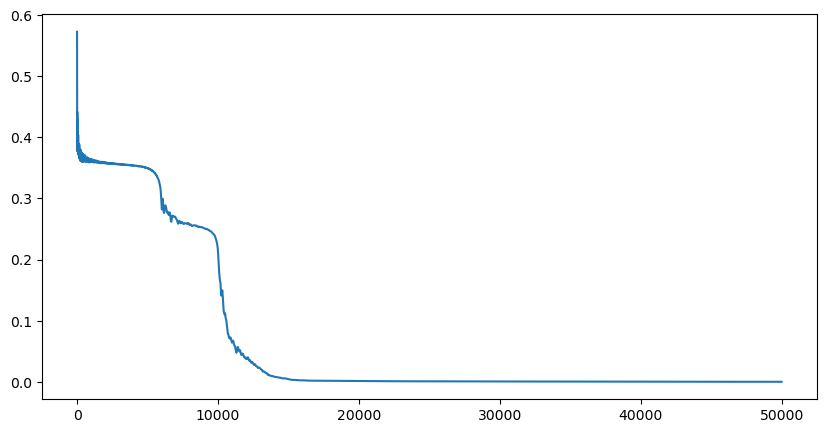

In [13]:
print(f"[Best][Epoch: {bep}] Train loss: {ls}") 
plt.figure(figsize=(10, 5))
plt.plot(loss_graph)
plt.show()

In [14]:
pinn.load_state_dict(torch.load('./'+eq+'_1d.pth'))

<All keys matched successfully>

In [25]:
if eq == 'bg':       
    t_test, x_test = bg_generator(101, 256, typ='test')
    t = np.linspace(0, 1, 101).reshape(-1,1)
    x = np.linspace(-1, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    print(u_pred.shape)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./burgers_shock.mat')  
    Exact = np.real(data['usol'])  
    err = u_pred[:,:-1]-Exact
    
elif eq == 'ac':
    t = np.linspace(0, 1, 201).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, 513)[:-1].reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    t_test = T_star.flatten()[:, None]
    x_test = X_star.flatten()[:, None]
    
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    print(test_variables)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    print(u_pred.shape)
    u_pred = u_pred.cpu().numpy().reshape(N,T)
    print(u_pred.shape)

    # reference data
    data = scipy.io.loadmat('./AC.mat')
    print(data)
    Exact = np.real(data['uu'])
    err = u_pred-Exact

err = np.linalg.norm(err,2)/np.linalg.norm(Exact,2)   
print(f"L2 Relative Error: {err}")

tensor([[ 0.0000, -1.0000],
        [ 0.0050, -1.0000],
        [ 0.0100, -1.0000],
        ...,
        [ 0.9900,  0.9961],
        [ 0.9950,  0.9961],
        [ 1.0000,  0.9961]], device='cuda:0')
torch.Size([102912, 1])
(512, 201)
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Nov 21 21:17:46 2017', '__version__': '1.0', '__globals__': [], 'tt': array([[0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
        0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
        0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
        0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
        0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
        0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 

6. Results

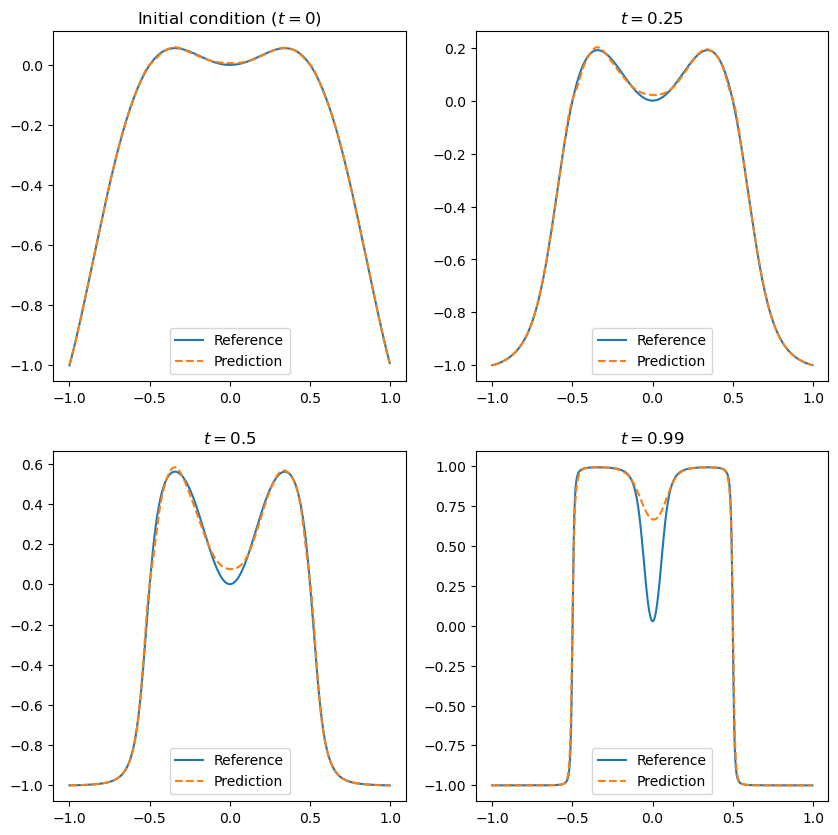

In [16]:
resplot(x, t, t_data, x_data, Exact, u_pred)

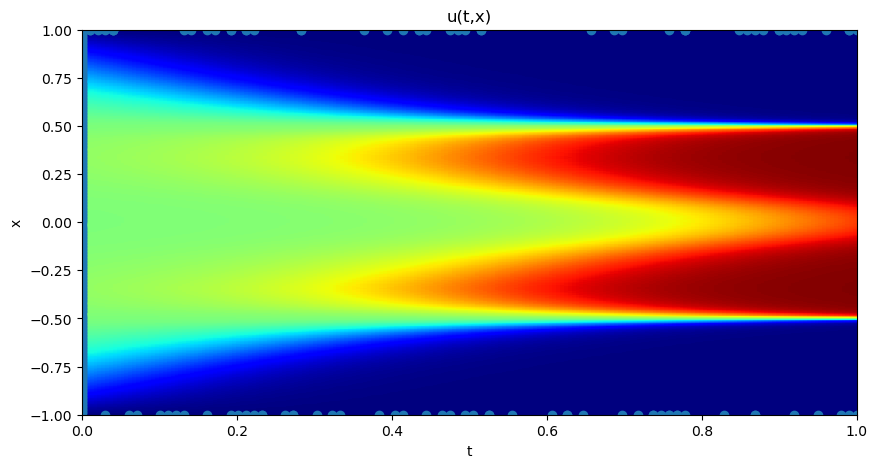

In [17]:
plt.figure(figsize=(10, 5))
plt.imshow(u_pred, interpolation='nearest', cmap='jet',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
plt.clim(-1, 1)
plt.ylim(-1,1)
plt.xlim(0,1)
plt.scatter(t_data, x_data)
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(t,x)')
plt.show()